# Post processing

In this notebook, we will see how to reload a trained model, and how to perform inference with it. We will also visualize what is happening inside the model, and how well it performs.

In [1]:
import os

import numpy as np
import tensorflow as tf

# Get rid of the deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from plotly import graph_objs as go
import matplotlib.pyplot as plt
import matplotlib as mpl

from tensorflow.python.lib.io import tf_record
from tensorflow.core.util import event_pb2
from tensorflow.python.framework import tensor_util

from models.models import GraphNeuralSolver

/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

### Importing model

In [2]:
# Enter path to mode
model_path = "results/1588091856"

# Enter path to data to build architecture
data_dir_build = 'datasets/poisson'

In [3]:
# Initialize a tensorflow session
sess = tf.Session()

# Build the Graph Neural Solver
model = GraphNeuralSolver(sess, 
                          model_to_restore=model_path, 
                          default_data_directory=data_dir_build)

### Importing data

Here you can import any data that has the same dimensions ($d_{in,A}$, $d_{in,B}$, $d_{out}$ and $d_{F}$) as the one used to build the Graph Neural Solver above. Indeed, if the distribution of the new data is too different from the dataset the model was trained on, the metrics may be quite bad.

In [4]:
# Enter path to data
data_dir = 'datasets/poisson'

# Select mode ('train', 'val' or 'test')
mode = 'test'

In [5]:
# Import numpy data
A_np = np.load(os.path.join(data_dir, 'A_'+mode+'.npy'))
B_np = np.load(os.path.join(data_dir, 'B_'+mode+'.npy'))
X_np = np.load(os.path.join(data_dir, 'X_'+mode+'.npy'))
coord_np = np.load(os.path.join(data_dir, 'coord_'+mode+'.npy'))

### Prediction on one sample

Here, we will perform inference on one sample from the imported dataset, and compare it to the solution provided by a classical approach.

In [6]:
# Randomly pick one sample
n_samples = np.shape(A_np)[0]
id_sample = np.random.randint(0, n_samples)

# Build feed_dict
feed_dict = {
    model.A:A_np[id_sample:id_sample+1], 
    model.B:B_np[id_sample:id_sample+1]
}

# Use the model to predict
X_pred = sess.run(model.X_final, feed_dict=feed_dict)

# Flatten the prediction
X_pred = np.reshape(X_pred, -1)

# Get the "ground truth" and flatten it
X_gt = X_np[id_sample]
X_gt = np.reshape(X_gt, -1)

# Our dataset is made of graphs with a varying amount of nodes, so we chose to pad
# each graph with dummy nodes to ensure that all tensors have the same size.
# Let's get rid of them for visualization purposes!

# Get non dummy nodes
useful_id = (X_gt!=0.)

# Filter out dummy nodes
X_gt = X_gt[useful_id]
X_pred = X_pred[useful_id]

# There is a bit of work to recreate the mesh...

# First, gather all the origin and extremity indices for each line
edges_or = A_np[id_sample, :, 0].astype(np.int32)
edges_ex = A_np[id_sample, :, 1].astype(np.int32)

# Filter the coordinates of the selected sample, and its non-dummy nodes
coord = coord_np[id_sample, useful_id]

# Gather, for each line the x and y coordinates of both its origin and extremity
coord_or_x = coord[edges_or, 0]
coord_or_y = coord[edges_or, 1]
coord_ex_x = coord[edges_ex, 0]
coord_ex_y = coord[edges_ex, 1]

# Concatenate all of that 
coord_edge_x = np.c_[coord_or_x, coord_ex_x]
coord_edge_y = np.c_[coord_or_y, coord_ex_y]

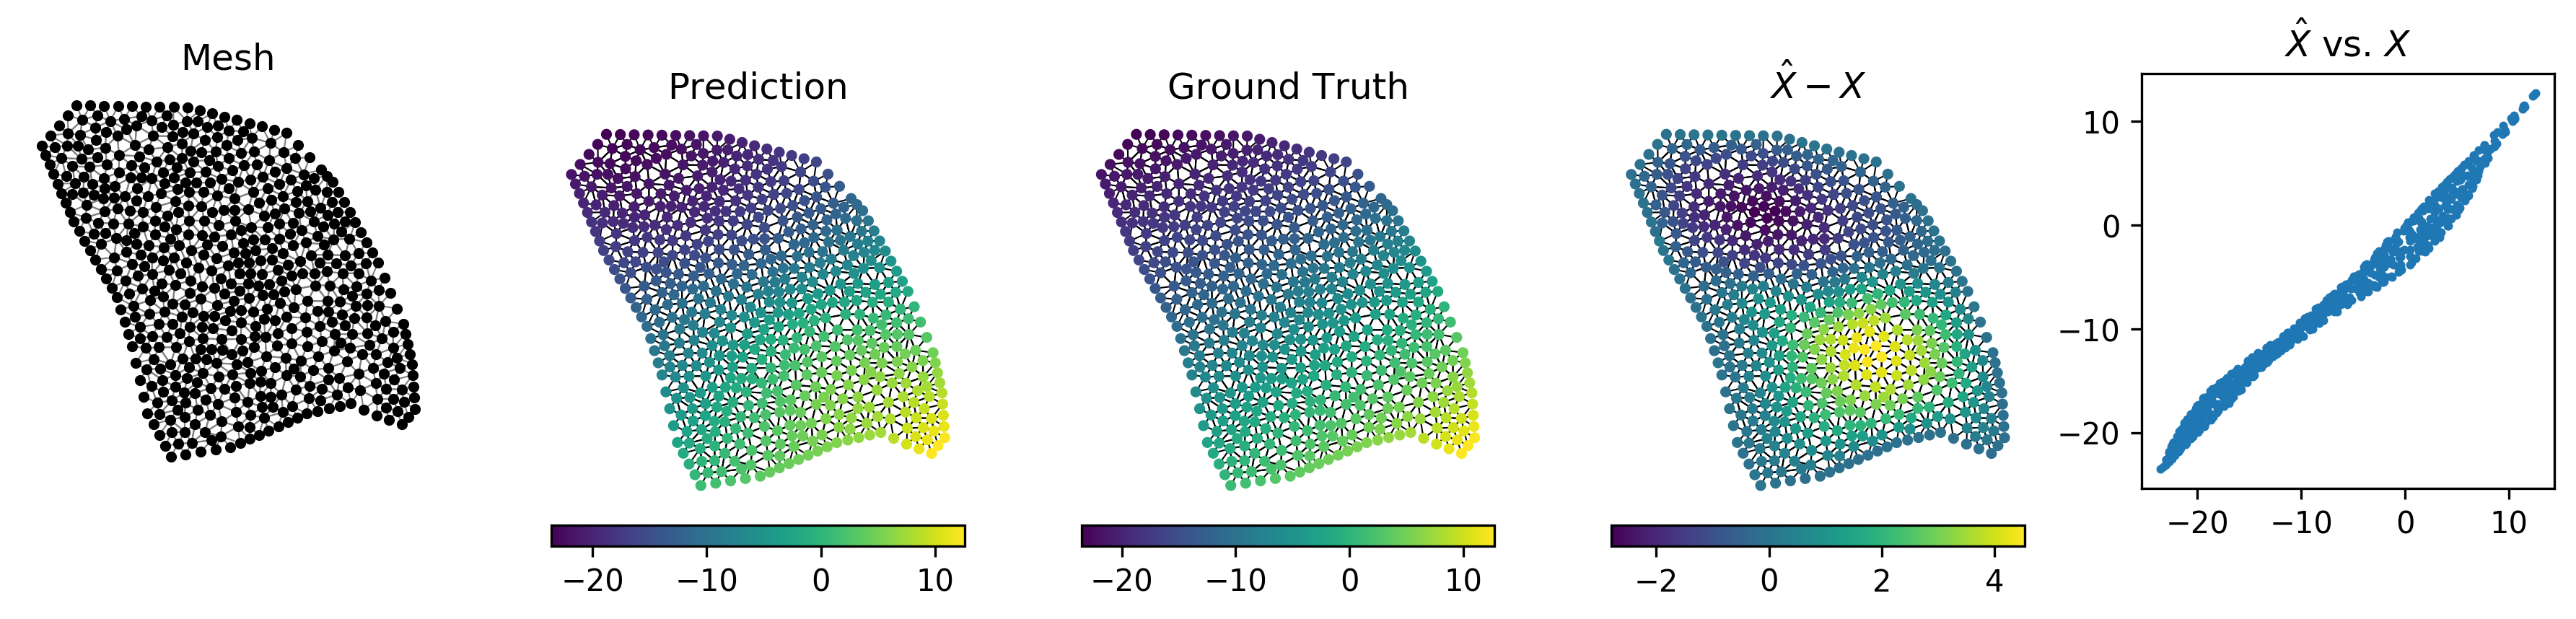

MAE = 1.2526740045033402
Relative residual = 0.021413582733848923


In [7]:
# 

node_size = 7
plt.figure(figsize=[12,3], dpi=300)

plt.subplot(1, 5, 1, aspect='equal')
plt.plot(coord_edge_x.T, coord_edge_y.T, 'grey', zorder=1, linewidth=0.5)
plt.scatter(coord[:,0], coord[:,1], c='k', zorder=2, s=node_size)
#plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Mesh')
plt.axis('off')

plt.subplot(1, 5, 2, aspect='equal')
plt.plot(coord_edge_x.T, coord_edge_y.T, 'k', zorder=1, linewidth=0.5)
plt.scatter(coord[:,0], coord[:,1], c=X_pred, zorder=2, s=node_size)
plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal")
plt.title('Prediction')
plt.axis('off')

plt.subplot(1, 5, 3, aspect='equal')
plt.plot(coord_edge_x.T, coord_edge_y.T, 'k', zorder=1, linewidth=0.5)
plt.scatter(coord[:,0], coord[:,1], c=X_gt, zorder=2, s=node_size)
plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal")
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 5, 4, aspect='equal')
plt.plot(coord_edge_x.T, coord_edge_y.T, 'k', zorder=1, linewidth=0.5)
plt.scatter(coord[:,0], coord[:,1], c=X_pred-X_gt, zorder=2, s=node_size)
plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal")
plt.title(r'$\hat{X}-X$')
plt.axis('off')

plt.subplot(1, 5, 5, aspect='equal')
plt.scatter(X_pred, X_gt, zorder=2, s=0.5*node_size)
plt.title(r'$\hat{X}$ vs. $X$')

plt.tight_layout()
plt.show()

print('MAE = {}'.format(np.mean(np.abs(X_pred-X_gt))))

print('Relative residual = {}'.format(np.sum((X_pred-X_gt)**2)/np.sum((X_gt)**2)))


In [8]:
X_pred_all, loss_all = sess.run([model.X_final,
                                            model.loss_final],
                  feed_dict={model.A:A_np[:1000], model.B:B_np[:1000]})

In [10]:
X_pred_all[:,0] = X_np[:1000,0]

X_pred_all_flat = np.reshape(X_pred_all, -1)
X_gt_all_flat = np.reshape(X_np[:1000], -1)
# error_all_flat = np.reshape(error_all, -1)
print('MAE Test = {}'.format(np.mean(np.abs(X_pred_all_flat-X_gt_all_flat))))
print('Loss Test = {}'.format(loss_all))
print('Var Test = {}'.format(np.sqrt(np.mean((X_pred_all_flat-X_gt_all_flat)**2))))
print('Relative res = {}'.format(np.sum((X_pred_all_flat-X_gt_all_flat)**2)/np.sum(X_gt_all_flat**2)))

MAE Test = 1.6434730388538796
Loss Test = 0.06034016236662865
Var Test = 3.3984719680168505
Relative res = 0.016783464380874958


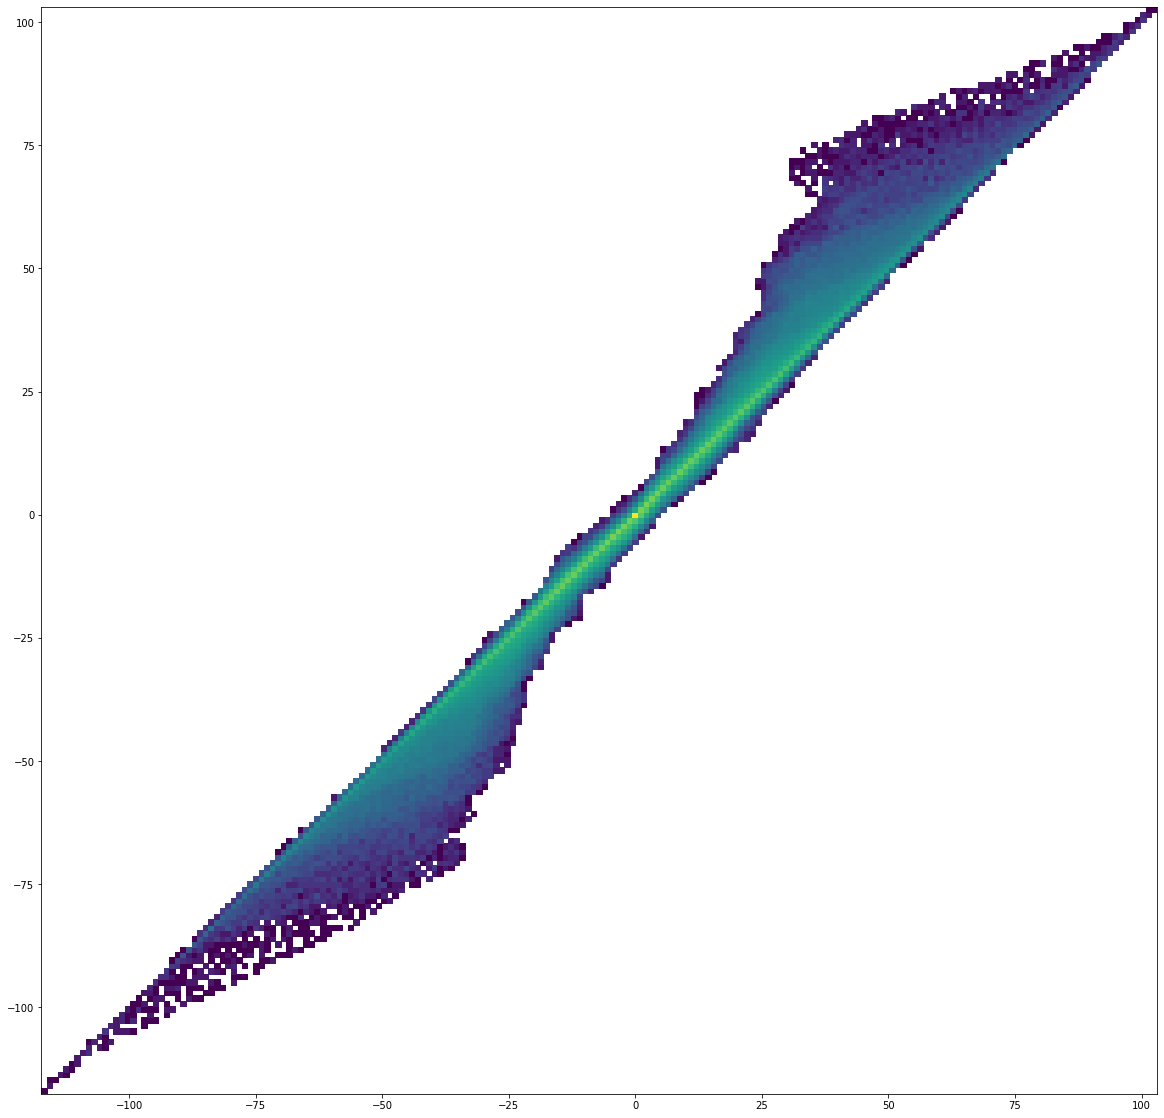

In [11]:
plt.figure(figsize=[20,20])
plt.hist2d(X_pred_all_flat, X_gt_all_flat,  bins=200, norm=mpl.colors.LogNorm())
#plt.scatter(X_pred, X_gt)
plt.show()

# Time series

In [28]:
id_sample = np.random.randint(0,np.shape(A_np)[0])

X_pred_time, error_time = sess.run([model.X, model.error], 
                  feed_dict={model.A:A_np[id_sample:id_sample+1], model.B:B_np[id_sample:id_sample+1]})


X_gt = X_np[id_sample, :, 0]
useful_id = (X_gt!=0.)
X_gt = X_gt[useful_id]

for key in X_pred_time.keys():
    X_pred_time[key] = X_pred_time[key][0, useful_id, 0]
    
for key in error_time.keys():
    error_time[key] = error_time[key][0, useful_id, 0]



edges_or = A_np[id_sample, :, 0].astype(np.int32)
edges_ex = A_np[id_sample, :, 1].astype(np.int32)

# Creating mesh coordinates
coordinates = coordinates_np[id_sample, useful_id]
coordinates_or_x = coordinates[edges_or, 0]
coordinates_or_y = coordinates[edges_or, 1]
coordinates_ex_x = coordinates[edges_ex, 0]
coordinates_ex_y = coordinates[edges_ex, 1]

coordinates_edge_x = np.c_[coordinates_or_x, coordinates_ex_x]
coordinates_edge_y = np.c_[coordinates_or_y, coordinates_ex_y]



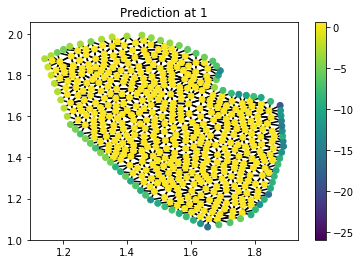

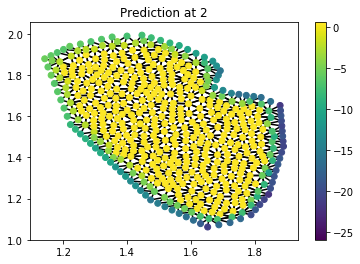

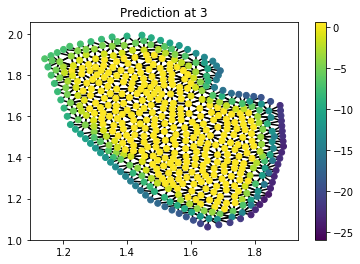

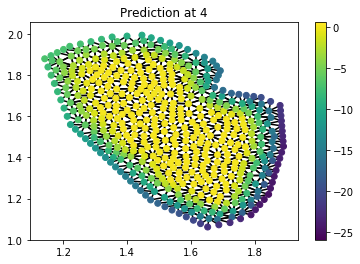

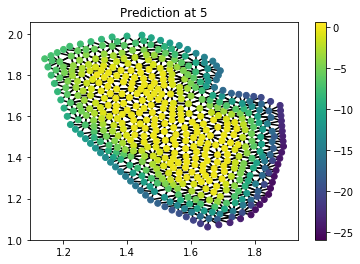

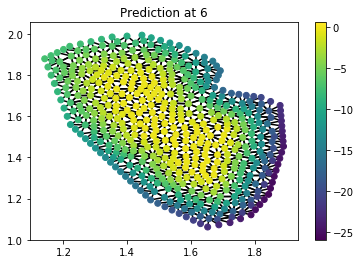

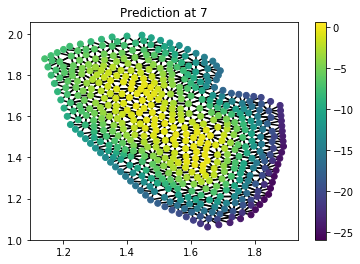

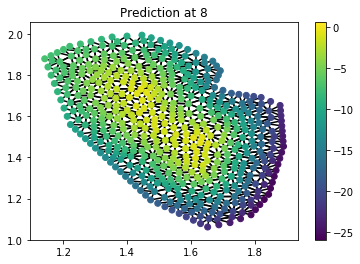

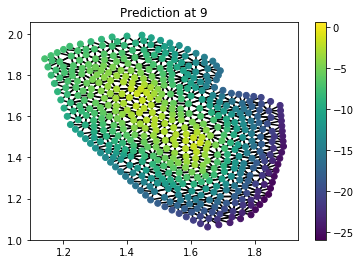

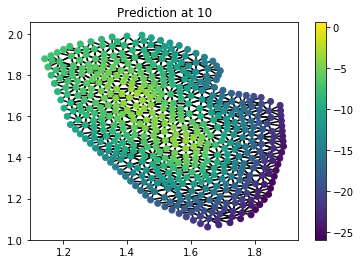

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-a99fadebd1d3>", line 5, in <module>
    plt.plot(coordinates_edge_x.T, coordinates_edge_y.T, 'k', zorder=1)
  File "/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/matplotlib/pyplot.py", line 2795, in plot
    is not None else {}), **kwargs)
  File "/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/matplotlib/axes/_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/matplotlib/axes/_base.py", line 225, in __call__
    yield from self._plot_args(this, kwargs)
  File "/Users/balthazardonon/Documents/PhD/Co

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x13ac6aea0> (for post_execute):


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/IPython/core/events.py", line 88, in trigger
    func(*args, **kwargs)
  File "/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py", line 121, in flush_figures
    return show(True)
  File "/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py", line 43, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/IPython/core/display.py", line 313, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver/ENV/lib/python3.6/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)


KeyboardInterrupt: 

In [14]:
max_x = np.max(np.array([u for u in X_pred_time.values()]))
min_x = np.min(np.array([u for u in X_pred_time.values()]))

for key in error_time.keys():
    plt.plot(coordinates_edge_x.T, coordinates_edge_y.T, 'k', zorder=1)
    plt.scatter(coordinates[:,0], coordinates[:,1], c=X_pred_time[key], zorder=2)
    plt.clim(min_x, max_x)
    plt.colorbar()
    plt.title('Prediction at '+key)
    plt.show()

In [ ]:
max_res = np.max(np.array([u-X_gt for u in X_pred_time.values()]))
min_res = np.min(np.array([u-X_gt for u in X_pred_time.values()]))

for key in error_time.keys():
    plt.plot(coordinates_edge_x.T, coordinates_edge_y.T, 'k', zorder=1)
    plt.scatter(coordinates[:,0], coordinates[:,1], c=X_pred_time[key]-X_gt, zorder=2)
    plt.clim(min_res, max_res)
    plt.colorbar()
    plt.title('Residual at '+key)
    plt.show()

In [ ]:
max_error = np.max(np.array([u**2 for u in error_time.values()]))
min_error = np.min(np.array([u**2 for u in error_time.values()]))

eps = 1e-5

for key in error_time.keys():
    plt.plot(coordinates_edge_x.T, coordinates_edge_y.T, 'k', zorder=1)
    plt.scatter(coordinates[:,0], coordinates[:,1], c=np.log(eps+error_time[key]**2), zorder=2)
    plt.clim(np.log(eps+min_error), np.log(eps+max_error))
    plt.colorbar()
    plt.title('Loss at '+key)
    plt.show()

In [29]:
X_pred_time_array = np.array([u for u in X_pred_time.values()])

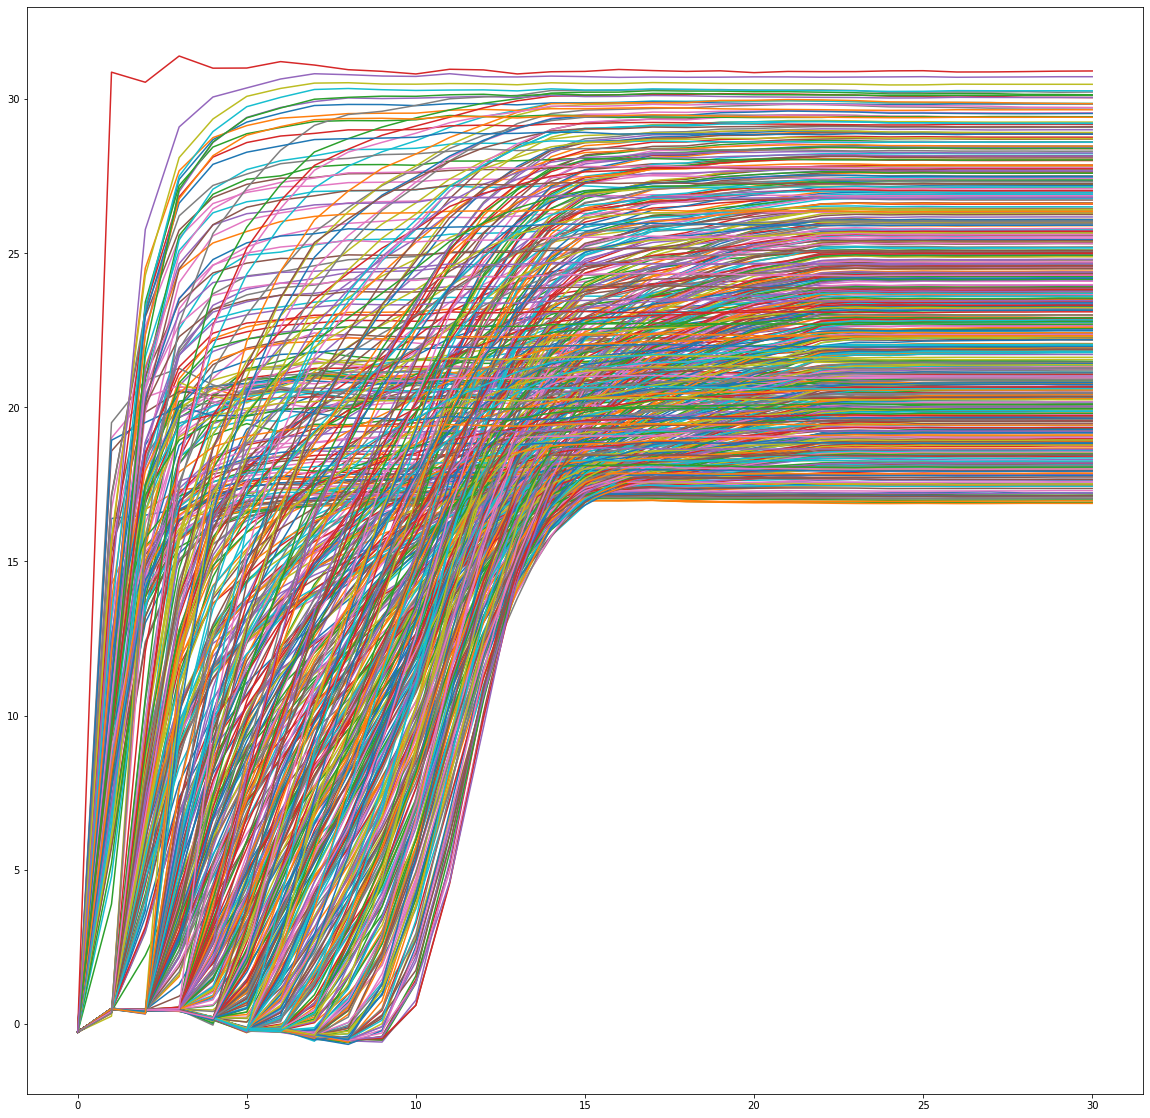

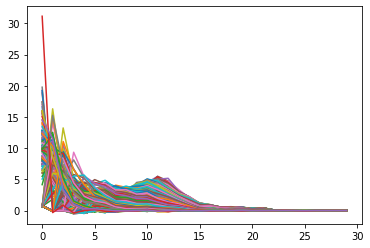

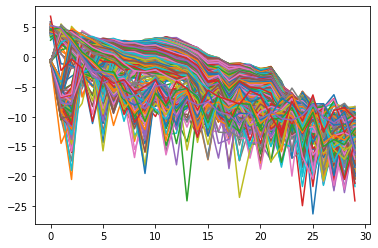

In [30]:
plt.figure(figsize=[20,20])
plt.plot(X_pred_time_array)
plt.show()
plt.plot(X_pred_time_array[1:]-X_pred_time_array[:-1])
plt.show()
plt.plot(np.log((X_pred_time_array[1:]-X_pred_time_array[:-1])**2))
plt.show()

In [31]:
loss_time = sess.run(model.loss, 
                     feed_dict={model.A:A_np[id_sample:id_sample+1], 
                                model.B:B_np[id_sample:id_sample+1]})
loss_time = np.array([u for u in loss_time.values()])

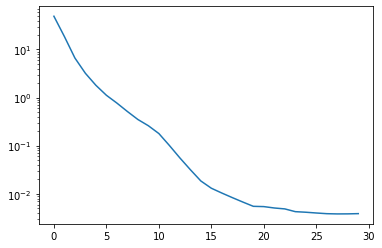

In [32]:
plt.plot(loss_time)
plt.yscale('log')
plt.show()

In [33]:
error_time = sess.run(model.error, 
                     feed_dict={model.A:A_np[id_sample:id_sample+1], 
                                model.B:B_np[id_sample:id_sample+1]})
error_time = np.array([u[0,:,0] for u in error_time.values()])

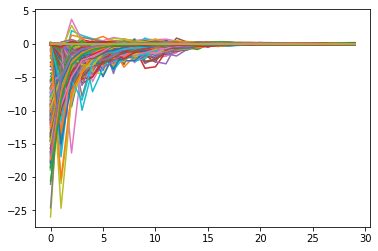

In [34]:
plt.plot(error_time)
plt.show()

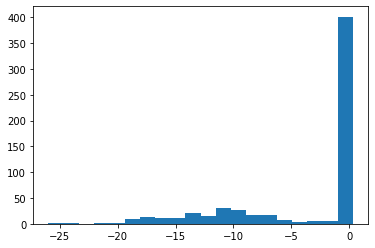

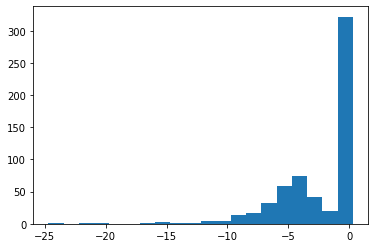

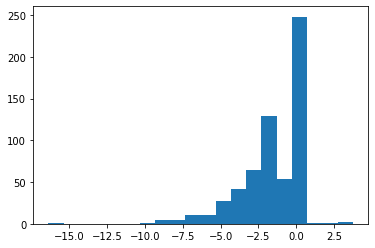

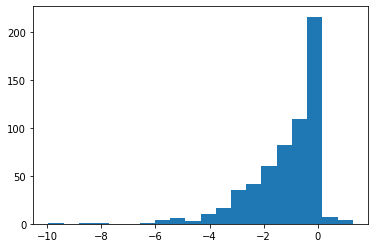

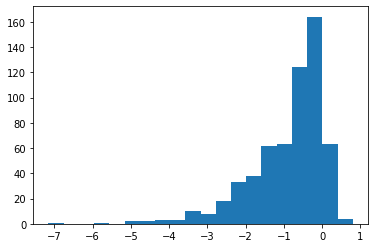

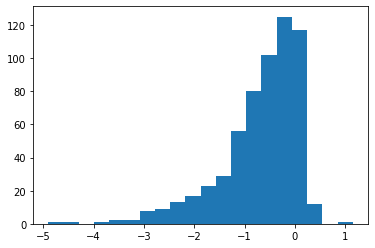

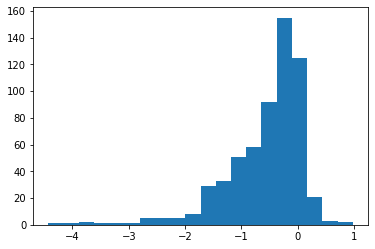

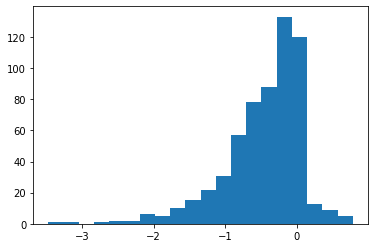

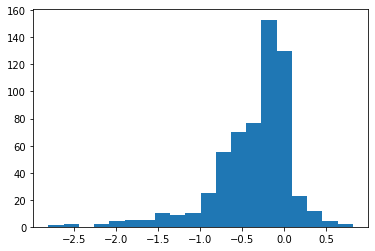

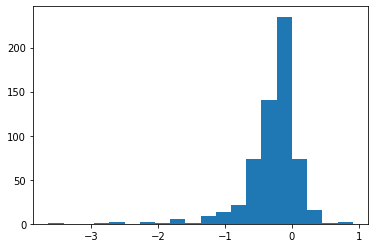

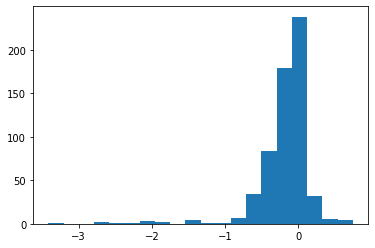

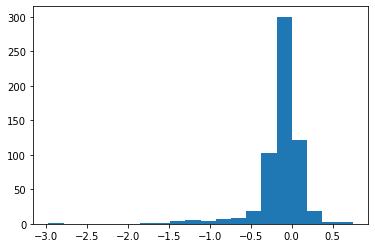

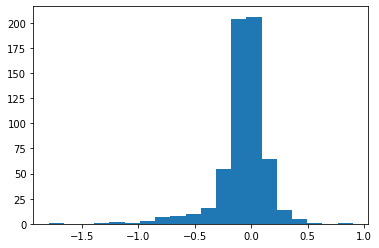

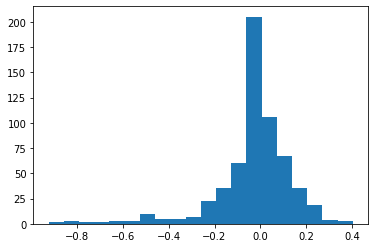

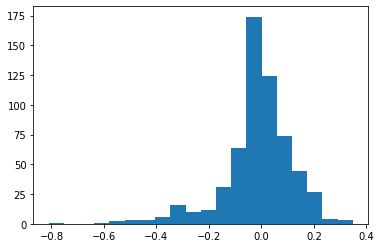

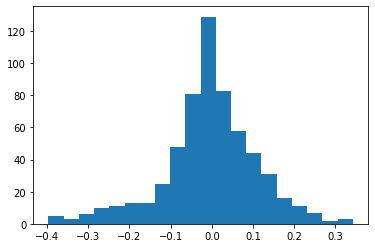

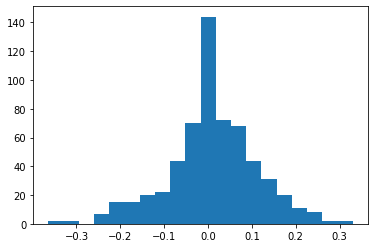

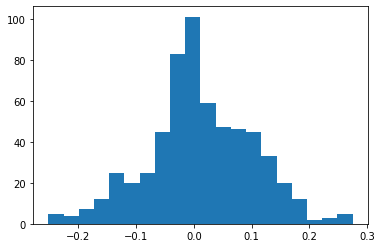

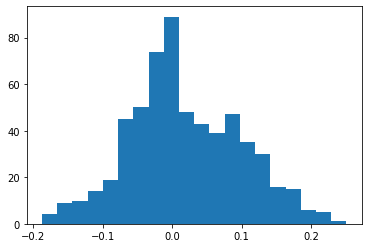

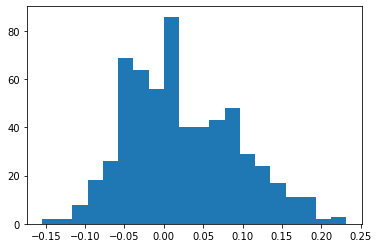

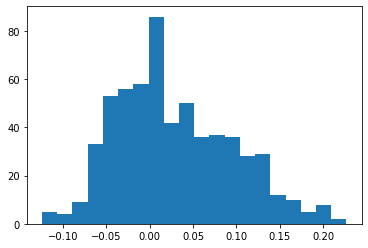

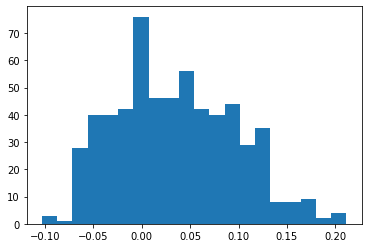

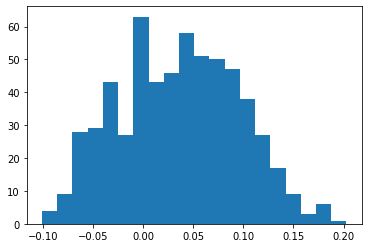

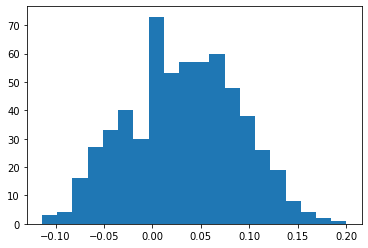

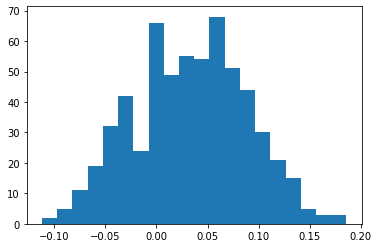

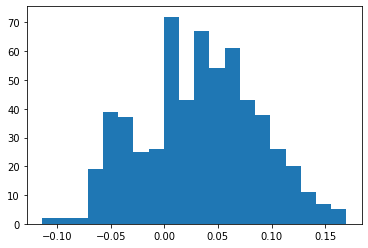

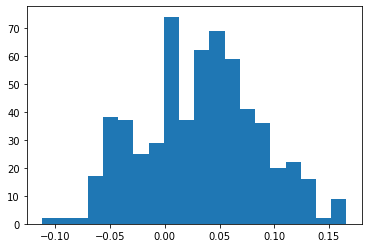

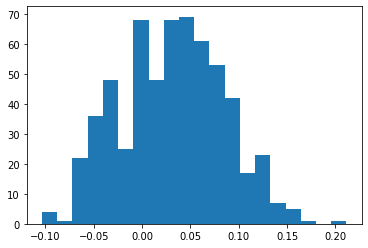

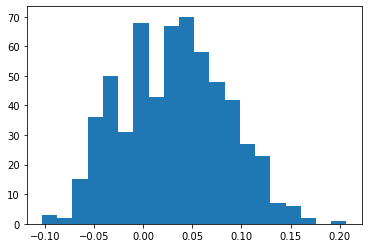

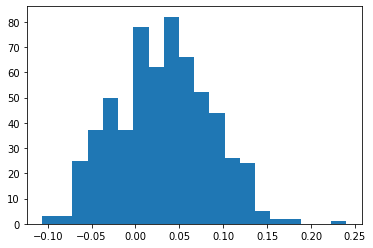

In [35]:
for i in range(np.shape(error_time)[0]):
    plt.hist(error_time[i], bins=20)
    plt.show()

In [ ]:
vars_ = sess.run(model.correction_block['29'].trainable_variables)

In [ ]:
for var in vars_:
    print(np.std(var))

In [ ]:
A_standard = np.load('datasets/poisson/various/A_train.npy')
A_alt = np.load('datasets/poisson_alt/various/A_train.npy')

In [ ]:
np.sum((A_standard[0,:,1]==0)*(A_standard[0,:,0]!=0))
# le noeud 0 n'est relié à rien...

In [ ]:
print(A_alt[0][:10])

In [ ]:
A_orig = np.load('datasets/poisson/various/A.npy', allow_pickle=True)

In [ ]:
A_orig[0].tocoo().row

In [ ]:
A_orig[0].tocoo().col

In [ ]:
B_orig = np.load('datasets/poisson/various/B.npy', allow_pickle=True)

In [ ]:
coord = np.load('datasets/poisson/various/coordinates.npy', allow_pickle=True)

In [ ]:
print(or_side)

In [ ]:
id_sample = np.random.randint(0,np.shape(A_np)[0])

or_side = A_orig[id_sample].tocoo().row
ex_side = A_orig[id_sample].tocoo().col

coord_or_x = coord[id_sample][or_side, 0]
coord_or_y = coord[id_sample][or_side, 1]

coord_ex_x = coord[id_sample][ex_side, 0]
coord_ex_y = coord[id_sample][ex_side, 1]

coord_edge_x = np.c_[coord_or_x, coord_ex_x]
coord_edge_y = np.c_[coord_or_y, coord_ex_y]

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(coord[id_sample][:,0], coord[id_sample][:,1])
plt.plot(coord_edge_x.T, coord_edge_y.T, 'k')
plt.show()

In [36]:
path = 'datasets/poisson_alt/various/test.tfrecords'
A = []

for serialized_example in tf.python_io.tf_record_iterator(path):

    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    A_sample = np.array(example.features.feature['A'].float_list.value)
    A_sample = np.reshape(A_sample, [-1, 3])

    A.append(A_sample)


In [37]:
A = np.array(A)

In [38]:
A_np = np.load('datasets/poisson_alt/various/A_test.npy')

In [39]:
print(A)

[[[ 4.          1.         -0.64041632]
  [ 4.          3.         -0.59984457]
  [ 4.          5.         -1.18879116]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 4.          1.         -0.64041632]
  [ 4.          3.         -0.59984457]
  [ 4.          5.         -1.18879116]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 4.          1.         -0.64041632]
  [ 4.          3.         -0.59984457]
  [ 4.          5.         -1.18879116]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 4.          1.         -1.03381371]
  [ 4.          3.         -0.89830643]
  [ 4.          5.         -1.14950597]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [

In [42]:
print(np.max(np.abs(A_np-A)))

5.960409121819055e-08
